In [ ]:
# BANK CUSTOMER CHURN PREDICTION
# =======================================================================================================
# Goal:
#   Build an end-to-end, reproducible pipeline that:
#       - explores the data and surfaces key churn drivers
#       - trains baseline classifiers
#       - tunes the best model
#       - evaluates performance with ROC-AUC / PR-AUC and interprets feature importance

# Notes:
#     - Categorical variables (`country`, `gender`) are one-hot encoded (drop first to avoid multicollinearity).
#     - `customer_id` is dropped (identifier; no predictive signal).
#     - Class imbalance exists (≈ 20% churn). 
#     - Metrics shown: Accuracy, ROC-AUC (primary), PR-AUC, confusion matrix, and classification report.
# =======================================================================================================

In [ ]:
# ================= 1) Imports ==================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

# =============== 2) Load & Inspect ===============
df = pd.read_csv('/users/pranaypakki/Tech/CSVfiles/BankCustomerChurnPrediction/Bank Customer Churn Prediction.csv')
print("Shape (rows, columns): ", df.shape)
df.head()

Shape (rows, columns):  (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
print(df.info())
print("=" * 100)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
        customer_id  credit_score           age        tenure        balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean 

In [ ]:
# ================================================================
# 3) DATA QUALITY CHECKS                                        
#    - Missing values, duplicates, target balance                
# ================================================================
print("Any Missing Values?:")
print(df.isnull().sum())
print("=" * 50)
print("Duplicated Values:  " + str(df.duplicated().sum()))
print("=" * 50)
print("Target Balance (Exited): ")
display(df['churn'].value_counts(normalize = True))

Any Missing Values?:
customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64
Duplicated Values:  0
Target Balance (Exited): 


churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Text(0, 0.5, 'Number of Customers')

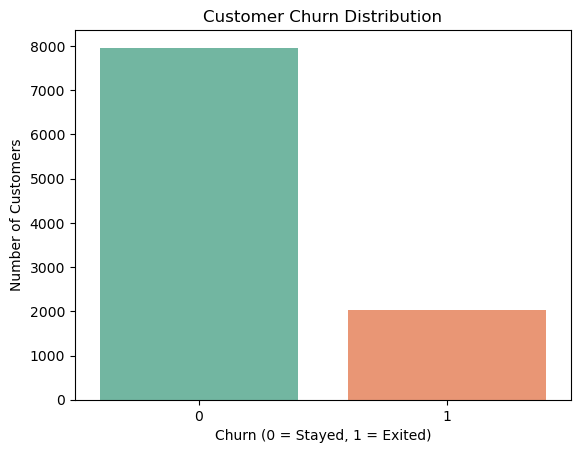

In [ ]:
# ================================================================
# 4) EXPLORATORY DATA ANALYSIS (EDA)                            
#    - Target distribution, churn vs gender/country, age, etc.   
# ================================================================
sns.countplot(data=df, x="churn", hue="churn", palette="Set2", legend=False)
plt.title('Customer Churn Distribution')
plt.xlabel('Churn (0 = Stayed, 1 = Exited)')
plt.ylabel('Number of Customers')

Text(0, 0.5, 'Churn Rate (%)')

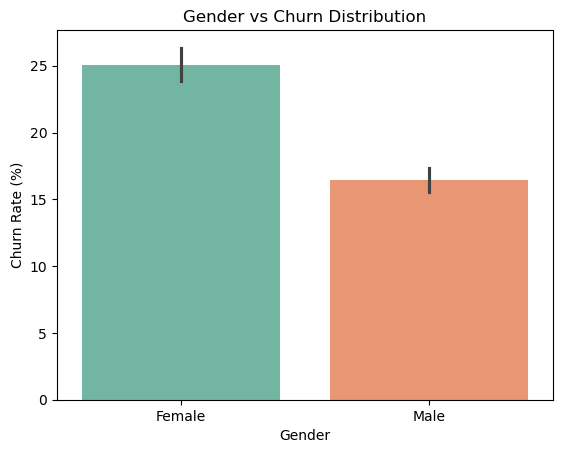

In [ ]:
sns.barplot(data=df, x='gender', y='churn', hue='gender', palette='Set2', legend=False, estimator=lambda x: 100*sum(x)/len(x))
plt.title('Gender vs Churn Distribution')
plt.xlabel('Gender')
plt.ylabel('Churn Rate (%)')

Text(0, 0.5, 'Churn Rate (%)')

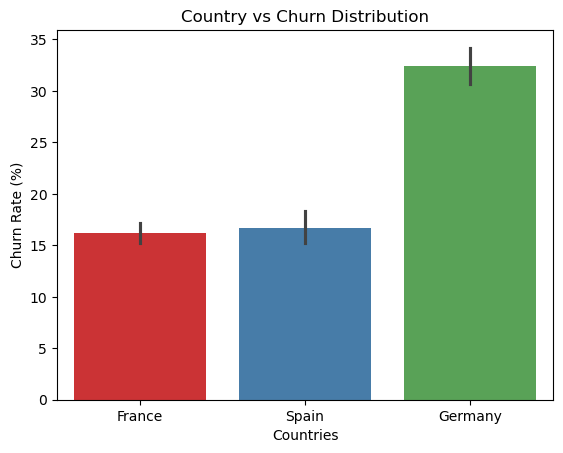

In [ ]:
sns.barplot(data=df, x='country', y='churn', hue='country', palette='Set1', legend=False, estimator=lambda x: 100*sum(x)/len(x))
plt.title('Country vs Churn Distribution')
plt.xlabel('Countries')
plt.ylabel('Churn Rate (%)')

Text(0.5, 0, 'Age')

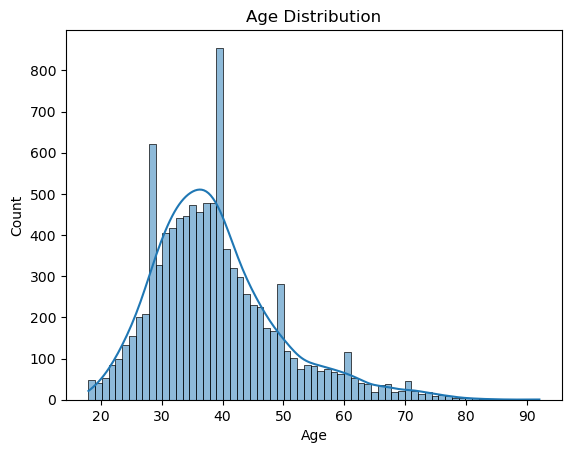

In [ ]:
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')

Text(0, 0.5, 'Balance')

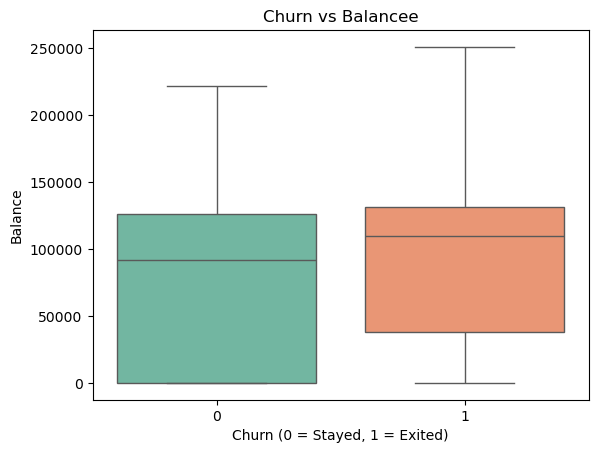

In [ ]:
sns.boxplot(data=df, x='churn', y='balance', hue='churn', palette='Set2', legend=False)
plt.title('Churn vs Balancee')
plt.xlabel('Churn (0 = Stayed, 1 = Exited)')
plt.ylabel('Balance')

<Axes: >

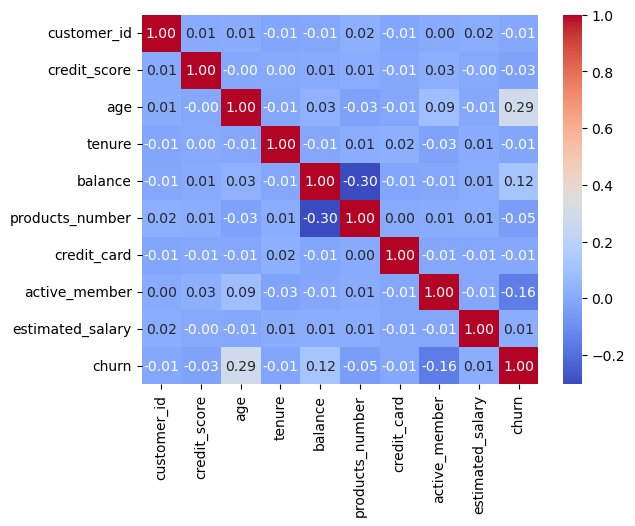

In [ ]:
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')

In [ ]:
# ================================================================
# 5) PREPROCESSING                                              
#    - Drop IDs, one-hot encode categoricals, dtype sanity check 
# ================================================================
df.drop(columns = ['customer_id'], inplace = True)

df = pd.get_dummies(data = df, columns = ['country','gender'], drop_first = True, dtype = int)

# Sanity Check
leftover = df.select_dtypes(include = 'object').columns
if len(leftover) > 0:
    print("Still have non-numeric columns: ", list(leftover))
else:
    print("All columns are numeric.")

All columns are numeric.


In [ ]:
# ================================================================
# 6) TRAIN / TEST SPLIT & SCALING                               
#    - Stratified split to preserve class balance                
#    - Standardize features for linear models                    
# ================================================================
X = df.drop('churn', axis = 1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_proba_lr = logreg.predict_proba(X_test_scaled)[:,1]

In [ ]:
rf = RandomForestClassifier(n_estimators = 300, random_state = 42, class_weight = "balanced", n_jobs = -1)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)[:,1]

In [ ]:
# ================================================================
# 7) EVALUATION TOOL                                                  
#    - Prints accuracy, ROC-AUC, PR-AUC, confusion matrix,       
#      classification report                                     
# ================================================================
def evaluate(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print("Model Name: ", name)
    print("Accuracy: ", acc)
    print("ROC-AUC: ", auc)
    print("Confusion Matrix: ")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report: ")
    print(classification_report(y_true, y_pred))

evaluate("Logistic Regression: ", y_test, y_pred_lr, y_proba_lr)
evaluate("Random Classifier: ", y_test, rf_pred, rf_proba)

Model Name:  Logistic Regression: 
Accuracy:  0.808
ROC-AUC:  0.7747778595236223
Confusion Matrix: 
[[1540   53]
 [ 331   76]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

Model Name:  Random Classifier: 
Accuracy:  0.863
ROC-AUC:  0.8541638711130236
Confusion Matrix: 
[[1546   47]
 [ 227  180]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.79      0.44      0.57       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.74      2000
weighted avg       0.86      0.86      0.85      2000



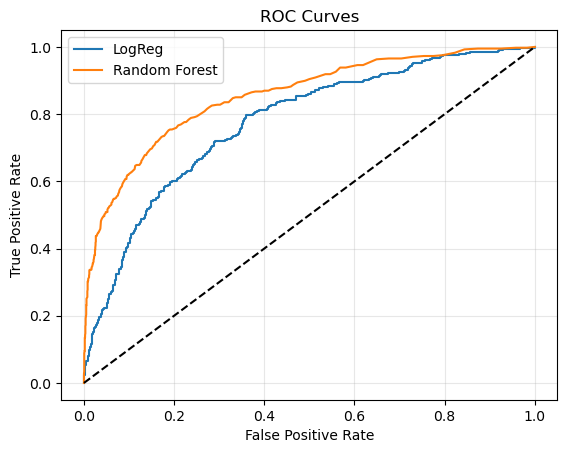

In [ ]:
# ================================================================
# 8) ROC CURVES                                                 
#    - Compare classifiers visually                              
# ================================================================
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

plt.plot(fpr_lr, tpr_lr, label = "LogReg")
plt.plot(fpr_rf, tpr_rf, label = "Random Forest")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# =============================================================================== 
# 9) CROSS-VALIDATION
#    – Performs 5-fold stratified cross-validation for both models
#    – Compares ROC-AUC and PR-AUC scores to evaluate consistency and robustness
# =============================================================================== 
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scoring = {"roc_auc" : "roc_auc", "pr_auc" : "average_precision"}
models = {
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter = 1000, class_weight = "balanced", random_state = 42)
    ),
    "Random Forest": make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators = 300, class_weight = "balanced_subsample", random_state = 42, n_jobs = -1)
    )
}

results = []
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True)
    results.append({
        "Model": name,
        "ROC-AUC Mean": np.mean(scores["test_roc_auc"]),
        "ROC-AUC Std": np.std(scores["test_roc_auc"]),
        "PR-AUC Mean": np.mean(scores["test_pr_auc"]),
        "PR-AUC Std": np.std(scores["test_pr_auc"]),
        "Train ROC-AUC Mean": np.mean(scores["train_roc_auc"]),
        "Train PR-AUC Mean": np.mean(scores["train_pr_auc"])
    })
    
results_df = pd.DataFrame(results).sort_values(by="ROC-AUC Mean", ascending=False)
print("Cross Validation Summary: ")
print(results_df.to_string(index=False, float_format = "%.3f"))

Cross Validation Summary: 
              Model  ROC-AUC Mean  ROC-AUC Std  PR-AUC Mean  PR-AUC Std  Train ROC-AUC Mean  Train PR-AUC Mean
      Random Forest         0.858        0.005        0.679       0.017               1.000              1.000
Logistic Regression         0.769        0.014        0.460       0.028               0.771              0.457


In [ ]:
# ================================================================================
# 10) HYPERPARAMETER TUNING & FEATURE IMPORTANCE
#    – Tunes Random Forest parameters using GridSearchCV for optimal performance
#    – Evaluates best model and visualizes top feature importances
# ================================================================================
rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)
param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 6, 10, 14],
    "min_samples_split": [2, 5, 10]
}
grid = GridSearchCV(rf, param_grid=param_grid, cv=cv, scoring=scoring, refit="pr_auc", n_jobs=-1)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, list(best_rf.classes_).index(1)]
evaluate("Tuned Random Forest: ", y_test, y_pred, y_proba)

Model Name:  Tuned Random Forest: 
Accuracy:  0.8515
ROC-AUC:  0.8621780486187265
Confusion Matrix: 
[[1463  130]
 [ 167  240]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.65      0.59      0.62       407

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000



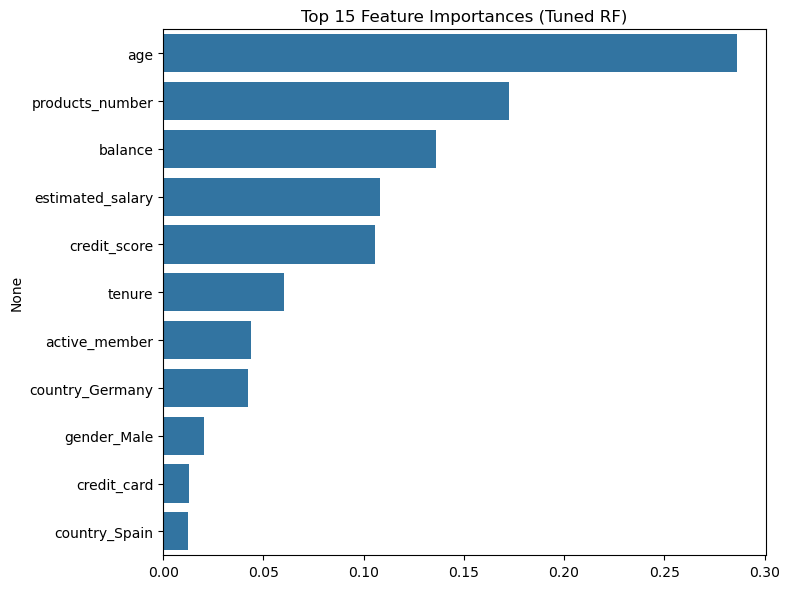

age                 0.286245
products_number     0.172305
balance             0.135836
estimated_salary    0.108118
credit_score        0.105663
tenure              0.060315
active_member       0.043775
country_Germany     0.042514
gender_Male         0.020272
credit_card         0.012655
country_Spain       0.012301
dtype: float64

In [ ]:
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title("Top 15 Feature Importances (Tuned RF)")
plt.tight_layout()
plt.show()

display(importances.head(20))

In [ ]:
# =======================================================================================================
# 11) CONCLUSION

# - Random Forest outperformed Logistic Regression with higher ROC-AUC and PR-AUC.  
# - Model tuning further improved performance, achieving strong accuracy and recall.  
# - Feature importance analysis showed 'age', 'products_number', and 'balance' as key drivers of churn.
# - The workflow ensures balanced evaluation through stratified splits, scaling, and cross-validation.
# =======================================================================================================